In [110]:
import numpy as np 
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [103]:
# Generate normal distribution
def generate_datapoint(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

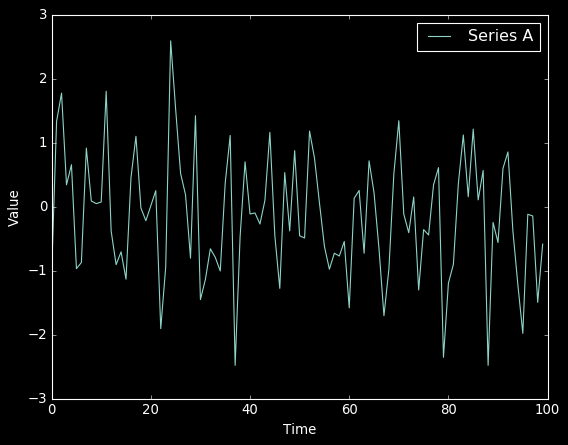

In [111]:
#Stationary time series A
params = (0, 1)
T = 100

A = pd.Series(index = range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_datapoint(params)

plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A']);

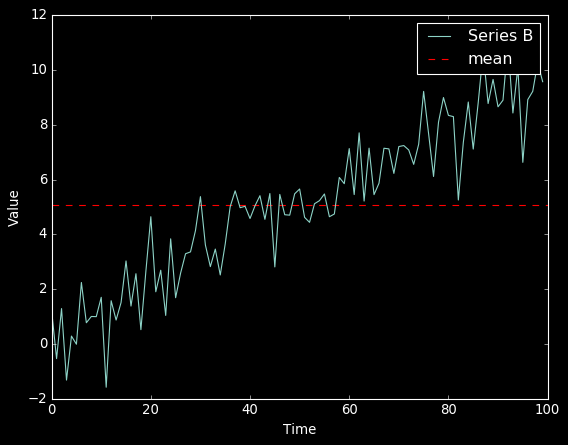

In [112]:
# Time series B
T = 100

B = pd.Series(index = range(T))
B.name = 'B'

for t in range(T):
    params = (t * 0.1, 1)
    # mean of series B would change overtime
    B[t] = generate_datapoint(params)

n = np.mean(B)
    
plt.plot(B)
plt.hlines(n, 0, len(B), linestyles = 'dashed', colors = 'r')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B','mean']);

## Testing for satationary

In [121]:
def check_for_stationary(X, cutoff = 0.01):
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print ('p-value = ' + str(pvalue) + ' this series'  + X.name + ' is likely stationary')
        return True
    else:
        print ('p-value = ' + str(pvalue) + ' this series'  + X.name + ' is likely non-stationary')
        return False

In [122]:
check_for_stationary(A)
check_for_stationary(B)

p-value = 1.317185696906544e-11 this seriesA is likely stationary
p-value = 0.7132151557395642 this seriesB is likely non-stationary


False

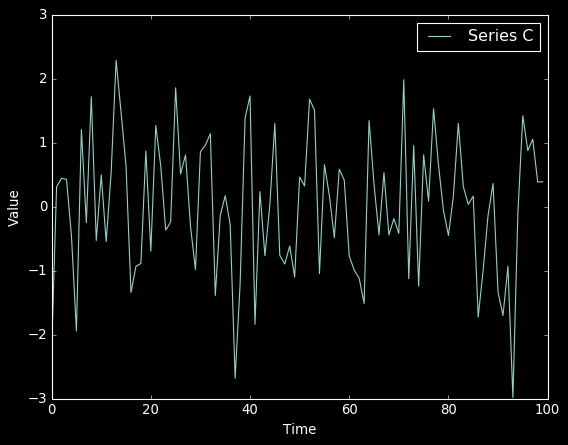

In [113]:
T = 100

C = pd.Series(index = range(T))
C.name = 'C'

for t in range(T):
    params = (np.sin(t), 1)
    # mean of series C would change overtime and it's also have maximum 1 and minimum -1
    # but this is still a random sample
    C[t] = generate_datapoint(params)

plt.plot(C)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series C']);

In [42]:
check_for_stationary(C)

p-value = 4.669594280486668e-10 this seriesC is likely stationary


True

Obviously we know this is not true, becase we alreday know this mean is a sin related function and it won't be a stationary case. So, in this situation, we are not be able to test the result.

#### Now we go back to series A

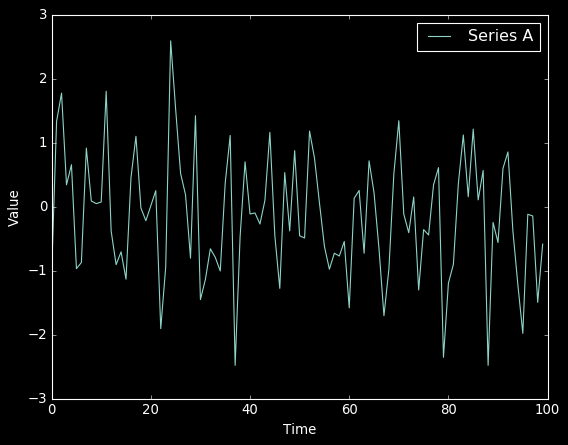

In [114]:
plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A']);

### Then accumulatice sum of A
#### *I(1)* Looks like price series

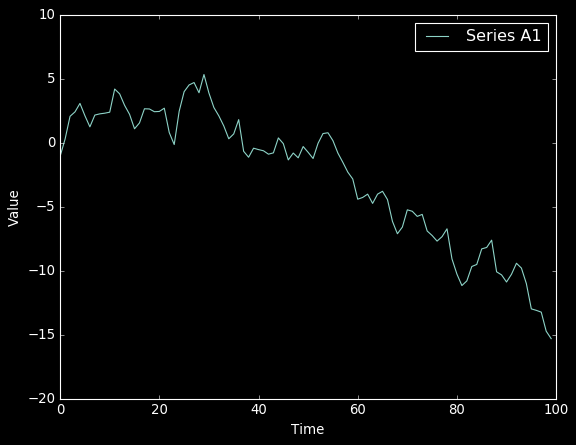

In [115]:
A1 = np.cumsum(A)

plt.plot(A1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A1']);

*I(2)*

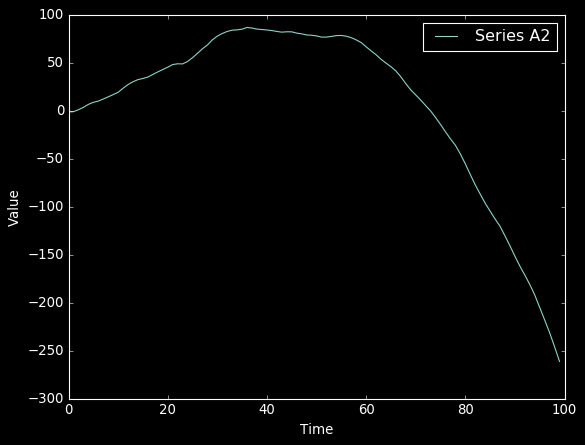

In [116]:
A2 = np.cumsum(A1)

plt.plot(A2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A2']);

### Pull in real data (Microsoft stock price)

In [117]:
start = dt.datetime(2015, 1, 1)
end = dt.datetime(2020, 11, 1)
df = web.DataReader('MSFT', 'yahoo', start, end)
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1469.000000,1469.000000,1469.000000,1469.000000,1.469000e+03,1469.000000
mean,97.393186,95.470987,96.459047,96.486576,3.062964e+07,93.508518
std,49.303208,47.995129,48.678703,48.680459,1.496017e+07,49.955066
min,40.740002,39.720001,40.340000,40.290001,7.425600e+06,35.983208
25%,55.660000,54.860001,55.299999,55.270000,2.141420e+07,50.759815
50%,84.610001,83.400002,84.139999,84.160004,2.698150e+07,80.600418
75%,127.970001,125.970001,126.620003,126.900002,3.482170e+07,124.819756
max,232.860001,227.350006,229.270004,231.649994,1.691640e+08,231.649994


In [92]:
X = df['Adj Close']

check_for_stationary(X)

p-value = 0.9974076677368615 this seriesAdj Close is likely non-stationary


False

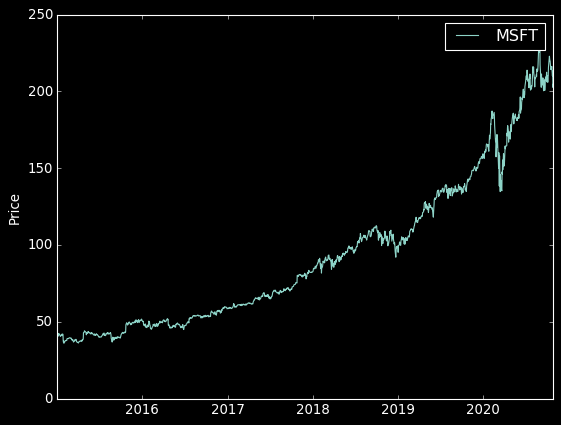

In [126]:
# plt.figure(figsize=(15,10))
plt.plot(X.index, X)
plt.ylabel('Price')
plt.legend(['MSFT']);

p-value = 1.6013197223538294e-16 this seriesAdj Close is likely stationary


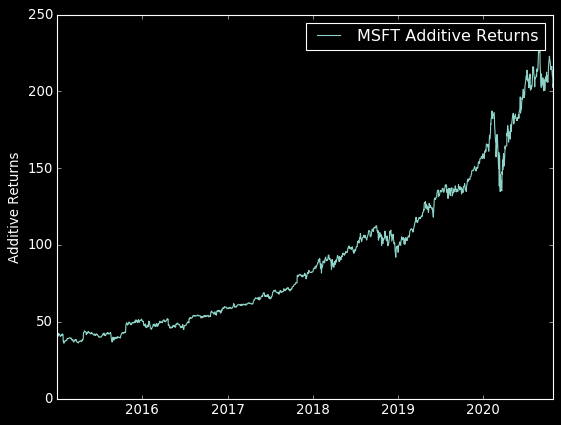

In [127]:
X1 = X.diff()[1:]
check_for_stationary(X1)
plt.plot(X.index, X)
plt.ylabel('Additive Returns')
plt.legend(['MSFT Additive Returns']);

Seems like the multiplicative returns are also stationary. Both the multiplicative and additive deltas on a series get at similar pieces of information, so it's not surprising both are stationary. In practice this might not always be the case.

As always, you should not naively assume that because a time series is stationary in the past it will continue to be stationary in the future. Tests for consistency of stationarity such as cross validation and out of sample testing are necessary. This is true of any statistical property, we just reiterate it here. Returns may also go in and out of stationarity, and may be stationary or non-stationary depending on the timeframe and sampling frequency.

### Note: Returns Analysis
The reason returns are usually used for modeling in quantitive finance is that they are far more stationary than prices. This makes them easier to model and returns forecasting more feasible. Forecasting prices is more difficult, as there are many trends induced by their $I(1)$ integration. Even using a returns forecasting model to forecast price can be tricky, as any error in the returns forecast will be magnified over time.
### Simulated Data Example

In [128]:
N = 100
# Generate a stationary random X1
X =np.random.normal(0, 1, N)
# integrate 
X1 = np.cumsum(X)
X1 = pd.Series(X1)
X1.name = 'X1'
# Make an X2 that is X1 plus some noise
X2 = X1 + np.random.normal(0, 1, N)
X2.name = 'X2'

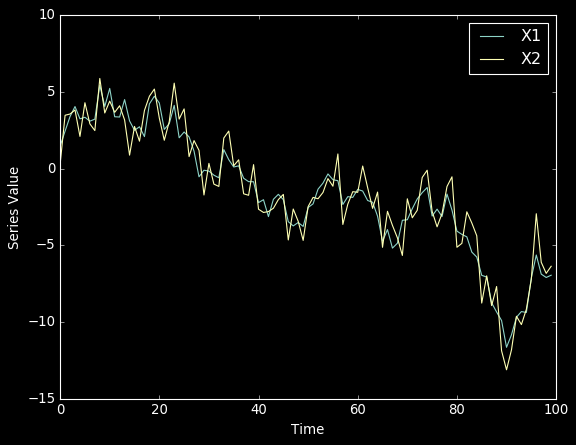

In [129]:
plt.plot(X1)
plt.plot(X2)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name]);

Because $X_2$ is just an $I(1)$ series plus some stationary noise, it should still be $I(1)$. Let's check this.

In [130]:
Z = X2.diff()[1:]
Z.name = 'Z'

check_for_stationary(Z)

p-value = 3.68238016582312e-16 this seriesZ is likely stationary


True

Looks good. Now to show cointegration we'll need to find some linear combination of $X_1$ and $X_2$ that is stationary. We can take $X_2-X_1$. All that's left over should be stationary noise by design. Let's check this.

p-value = 1.540552835005795e-18 this seriesZ is likely stationary


True

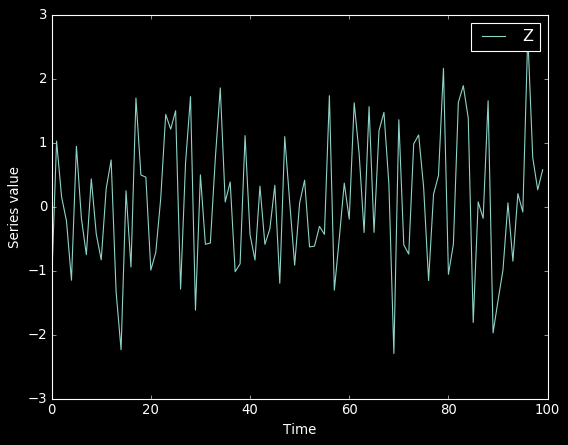

In [132]:
Z = X2 - X1
Z.name = 'Z'

plt.plot(Z)
plt.xlabel('Time')
plt.ylabel('Series value')
plt.legend('Z');

check_for_stationary(Z)

### Testing for Cointegration
There are a bunch of ways to test for cointegration. 

In practice a common way to do this for pairs of time series is to use linear regression to estimate $\beta$ in the following model.

$$X_2 = \alpha + \beta X_1 + \epsilon$$
The idea is that if the two are cointegrated we can remove $X_2$'s depedency on $X_1$, leaving behind stationary noise. The combination $X_2 - \beta X_1 = \alpha + \epsilon$ should be stationary.

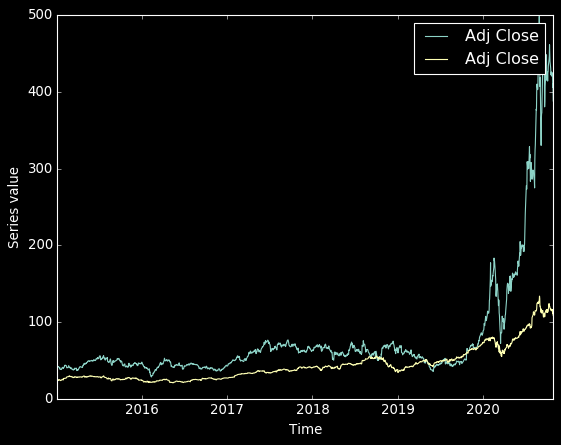

In [146]:
start = dt.datetime(2015, 1, 1)
end = dt.datetime(2020, 11, 1)
df_TSLA = web.DataReader('TSLA', 'yahoo', start, end)
df_AAPL = web.DataReader('AAPL', 'yahoo', start, end)

X_TSLA = df_TSLA['Adj Close']
X_AAPL = df_AAPL['Adj Close']

plt.plot(X_TSLA.index, X_TSLA)
plt.plot(X_AAPL.index, X_AAPL)
plt.xlabel('Time')
plt.ylabel('Series value')
plt.legend([X_TSLA.name, X_AAPL.name]);